In [250]:
import torch as th
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt

In [251]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [252]:
class SimpleFCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(SimpleFCNN, self).__init__()
        self.relu = nn.ReLU()
        # initialize the first layer
        self.first_layer = nn.Linear(input_size, hidden_size)
        self.num_layers = num_layers
        # initialize the layers
        for i in range(num_layers - 2):
            setattr(self, f"fc{i}", nn.Linear(hidden_size, hidden_size))

        # initialize last layer extra
        self.last_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # apply first layer
        x = self.relu(self.first_layer(x))
        # iterate over all layers but the last one
        for i in range(self.num_layers - 2):
            x = self.relu(getattr(self, f"fc{i}")(x))
        # apply last layer without relu
        x = self.last_layer(x)
        return x

class CouplingLayer(nn.Module):
    def __init__(self, num_features, hidden_size, num_layers, num_conds):
        super(CouplingLayer, self).__init__()
        # Initialize the fully connected network
        upper_split_size = math.ceil(num_features / 2)
        lower_split_size = num_features - upper_split_size
        # self.t = SimpleFCNN(
        #     upper_split_size, hidden_size, 2*lower_split_size, num_layers
        # )
        self.s = SimpleFCNN(
            upper_split_size + num_conds, hidden_size, 2*lower_split_size, num_layers
        )

    def forward(
        self,
        x,
        cond,
    ):
        x_1, x_2 = th.tensor_split(x, 2, dim=1)
        x_1_tilde = th.cat((x_1, cond), dim=1)
        s, t = th.tensor_split(self.s(x_1_tilde), 2, dim=1)
        # Forward pass through the coupling layer
        x_2 = th.abs(s) * x_2 + t
        log_det_J = th.sum(th.log(th.abs(s)), dim=1)
        return th.cat((x_1, x_2), dim=1), log_det_J

    def backward(self, x, cond):
        x_1, x_2 = th.tensor_split(x, 2, dim=1)
        x_1_tilde = th.cat((x_1, cond), dim=1)
        s, t = th.tensor_split(self.s(x_1_tilde), 2, dim=1)
        # Forward pass through the coupling layer
        x_2 = (x_2 - t) / th.abs(s)
        return th.cat((x_1, x_2), dim=1)

class CINN(nn.Module):
    def __init__(self, num_blocks, num_features, hidden_size, num_layers, cond_hidden_size, cond_num_layers, num_conditions=2):
        super(CINN, self).__init__()

        self.num_blocks = num_blocks


        for i in range(num_blocks - 1):
            setattr(
                self,
                f"cl_{i}",
                CouplingLayer(
                    num_features, hidden_size, num_layers, num_conds = 4*num_conditions),
            )

        self.last_block = CouplingLayer(
            num_features, hidden_size, num_layers, num_conds = 4*num_conditions
        )

        self.condition = SimpleFCNN(num_conditions, cond_hidden_size, 4*num_conditions*num_blocks, cond_num_layers)

    def forward(self, x, cond):
        log_det_J = 0
        conds = self.condition.forward(cond)
        conds = th.tensor_split(conds, self.num_blocks, dim=1)
        for i in range(self.num_blocks - 1):
            x, _log_det_J = getattr(self, f"cl_{i}").forward(x, conds[i])
            x = x[:,[2, 0, 1]]
            log_det_J += _log_det_J
            
        x, _log_det_J = self.last_block.forward(x, conds[-1])
        log_det_J += _log_det_J
        return x, log_det_J

    def backward(self, x, cond):
        conds = self.condition.forward(cond)
        conds = th.tensor_split(conds, self.num_blocks, dim=1)
        x = self.last_block.backward(x, conds[-1])
        for i in range(self.num_blocks - 2, -1, -1):
            x = x[:,[1, 2, 0]]
            x = getattr(self, f"cl_{i}").backward(x, conds[i])
        return x
    


In [253]:
def calc_next_point(points, angles):
    alpha = angles
    # beta = th.maximum(th.pi / 2 - th.abs(alpha), th.tensor(0))
    beta = th.pi / 2 - th.abs(alpha)
    x = th.sin(beta) + points[:, 0]
    y_m = alpha / th.abs(alpha) * th.cos(beta) + points[:, 1]
    next_point = th.vstack((x, y_m)).T
    return next_point


def calc_arm_pos(angles):
    first_point = calc_next_point(th.tensor([[0, 0]]), angles[:, 0])
    middle_point = calc_next_point(first_point, angles[:, 1])
    last_point = calc_next_point(middle_point, angles[:, 2])
    return th.cat(
        (
            th.tensor([[[0, 0]]] * len(angles)),
            first_point.unsqueeze(1),
            middle_point.unsqueeze(1),
            last_point.unsqueeze(1),
        ),
        dim=1,
    )


def calc_y(angles):
    return calc_arm_pos(angles)[:, -1]


def data_generator(n):
    scaling_factor = 1
    angles = (
        th.distributions.uniform.Uniform(-th.pi / 2, th.pi / 2).sample(
            (3 * n,)
        )
        * scaling_factor
    )
    x = angles.reshape(n, 3)

    y = calc_y(x)

    return x, y

In [254]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
    
    def Isotropic_Gaussian(self, x):
        xx = th.sum(x ** 2, axis=1)    
        return -0.5 * (xx - 2*th.log(th.tensor(2 * th.pi)))

    def forward(self, x, log_det_J, model, y, lambda_1 = 1e-3):
        mse_penalty = th.nn.MSELoss(size_average=False)
        reg_loss = 0

        mseloss =th.nn.MSELoss(size_average=False)
        n = x.shape[0]
        
        for param in model.parameters():
            reg_loss += mse_penalty(param, th.zeros_like(param)) #
        return -th.sum(self.Isotropic_Gaussian(x) + log_det_J),  -th.sum(self.Isotropic_Gaussian(x) + log_det_J)

In [255]:
num_features = 3  # Number of features in the input
hidden_size = 12  # Number of hidden units in the FCNN
num_layers = 4  # Number of layers in the FCNN
num_blocks = 4  # Number of coupling layers in the flow
num_conditions = 2  # Number of conditions
cond_hidden_size = 16  # Number of hidden units in the FCNN for the conditions
cond_num_layers = 4  # Number of layers in the FCNN for the conditions


# Initialize the flow
flow = CINN(num_blocks, num_features, hidden_size, num_layers, cond_hidden_size, cond_num_layers, num_conditions)

# Initialize the loss
lossfunc = Loss()
flow.to(device)
loss_arr = []

n = 1000
x, y = data_generator(n)

In [256]:
optimizer = th.optim.RMSprop(
    [
        {"params": flow.parameters(), "lr": 1e-2},
    ]
)
dataloader = th.utils.data.DataLoader(list(zip(x, y)), batch_size=2000, shuffle=True)
sheduler = th.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.5)
for i in range(100000):
    epochloss = 0
    epochcounter = 0
    epochcleanedloss = 0
    for x_batch , y_batch in dataloader:
        optimizer.zero_grad()
        loss = 0.0
        y_pred, log_det_J = flow.forward(x_batch.float(), y_batch.float())
        loss, cleaned_loss = lossfunc.forward(y_pred.float(), log_det_J, flow, y_batch.float())
        epochloss += loss
        epochcleanedloss += cleaned_loss
        epochcounter += 1
        loss_arr.append(cleaned_loss.cpu().item())
        loss.backward()

        optimizer.step()
        sheduler.step()
    if i % 100 == 0:
        print("Epoch: " + str(i) + " Loss: " + str(epochloss.item()/epochcounter))


Epoch: 0 Loss: 7869.40380859375
Epoch: 100 Loss: -1074.2493896484375
Epoch: 200 Loss: -1475.1568603515625
Epoch: 300 Loss: -2130.914794921875
Epoch: 400 Loss: -2226.66650390625
Epoch: 500 Loss: -2606.3408203125
Epoch: 600 Loss: -2513.9736328125
Epoch: 700 Loss: -2806.611328125
Epoch: 800 Loss: -1427.353759765625
Epoch: 900 Loss: -3088.265869140625
Epoch: 1000 Loss: -2243.59912109375
Epoch: 1100 Loss: -2999.1796875
Epoch: 1200 Loss: -3382.184326171875
Epoch: 1300 Loss: -2088.549560546875
Epoch: 1400 Loss: -3050.8671875
Epoch: 1500 Loss: -3419.258056640625
Epoch: 1600 Loss: -2292.664306640625
Epoch: 1700 Loss: -2718.95068359375
Epoch: 1800 Loss: -3236.81005859375
Epoch: 1900 Loss: -3481.581787109375
Epoch: 2000 Loss: -3368.1611328125
Epoch: 2100 Loss: -3953.415283203125
Epoch: 2200 Loss: -3694.73583984375
Epoch: 2300 Loss: -2977.242431640625
Epoch: 2400 Loss: -3140.470947265625
Epoch: 2500 Loss: -2391.963134765625
Epoch: 2600 Loss: -2681.67919921875
Epoch: 2700 Loss: -3643.71826171875
Ep

Text(0, 0.5, 'Negative Log Likelihood')

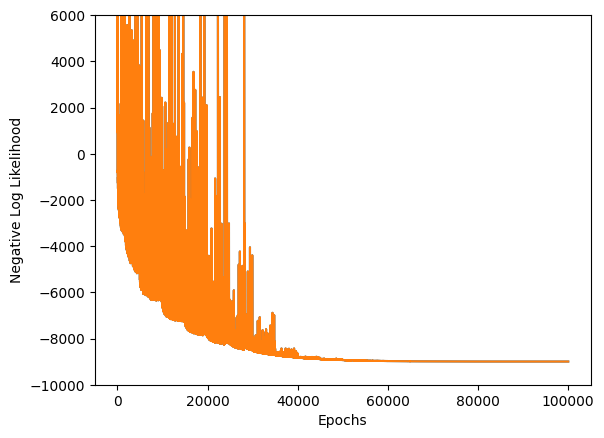

In [277]:
plt.plot(loss_arr)
plt.plot(loss_arr)
plt.ylim(-10000, 6000)
plt.xlabel("Epochs")
plt.ylabel("Negative Log Likelihood")

In [258]:

col_red = "#c61826"
col_dark_red = "#590d08"
col_blue = "#01024d"

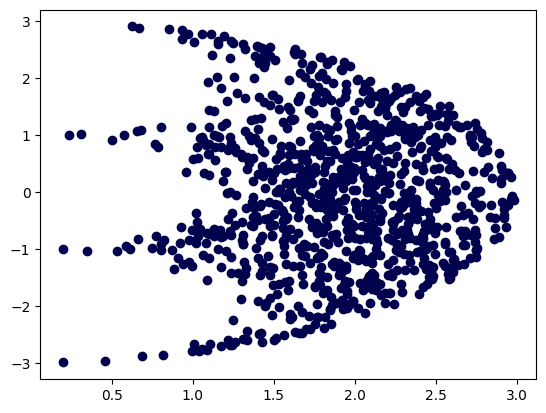

In [259]:
plt.scatter(calc_y(x).detach().numpy()[:, 0], calc_y(x).detach().numpy()[:, 1], c = col_blue)

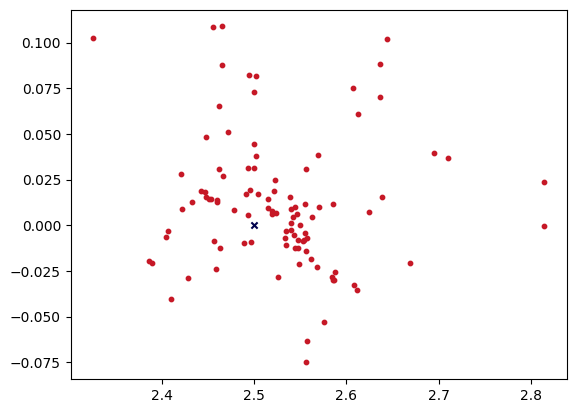

In [260]:
target = [2.5, 0.0]
samples = th.tensor(np.random.normal([0, 0, 0], 1, size = (100, 3))).to(device)
y = [target] * 100
y = th.tensor(y).to(device)
result = flow.backward(samples.float(), y.float())  

import matplotlib.pyplot as plt
result_y = calc_y(result).detach().numpy() 
# print(result)
plt.scatter(result_y[:, 0], result_y[:, 1],s=10,color = col_red, label='Forward Simulation of generated samples')
plt.scatter(target[0], target[1], marker = 'x', s = 20, color=col_blue, label='Original Condition')

samples = samples.detach().numpy()
result = result.detach().numpy()

In [261]:
print(np.mean(result_y, axis=0))

[2.5271912  0.01224797]


In [262]:
print(np.cov(result_y[:, 0], result_y[:, 1]))

[[ 0.00644213 -0.00022218]
 [-0.00022218  0.00133647]]


In [263]:
print(np.mean(np.sqrt((result_y[:, 0] - target[0])**2 + (result_y[:, 1] - target[1])**2)))

0.07455192


In [264]:
print(np.max(np.sqrt((result_y[:, 0] - target[0])**2 + (result_y[:, 1] - target[1])**2)))

0.31460252


In [265]:
print(np.min(np.sqrt((result_y[:, 0] - target[0])**2 + (result_y[:,1] - target[1])**2)))

0.008049494


Percentage of points inside the area: 0.79
Percentage of points outside the area: 0.21


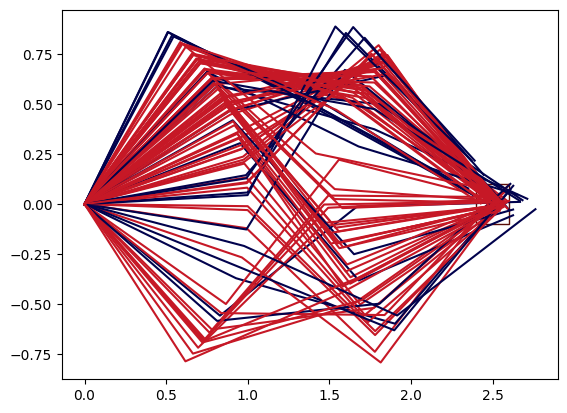

In [275]:
import matplotlib.patches as patches

n = 100
x_ = 2.5
y_ = 0.0
in_counter = 0
out_counter = 0
tol_area = 0.1
samples = th.tensor(np.random.normal([0, 0, 0], 1, size = (n, 3))).to(device)
y = [[x_, y_]] * n
y = th.tensor(y).to(device)
result = flow.backward(samples.float(), y.float())  

arm_pos = calc_arm_pos(result ).detach().numpy()
plt.figure()
arm_pos = calc_arm_pos(result).cpu().detach().numpy()

for i in range(len(arm_pos)):
    if (
        arm_pos[i, -1, 0] > x_ + tol_area
        or arm_pos[i, -1, 0] < x_ - tol_area
        or arm_pos[i, -1, 1] > y_ + tol_area
        or arm_pos[i, -1, 1] < y_ - tol_area
    ):
        out_counter += 1
        plt.plot(
            arm_pos[i, :, 0],
            arm_pos[i, :, 1],
            label="Original Data",
            c=col_blue,
            alpha=1,
        )
    else:
        in_counter += 1
        plt.plot(
            arm_pos[i, :, 0],
            arm_pos[i, :, 1],
            label="Original Data",
            c=col_red,
            alpha=1,
        )
rec = patches.Rectangle((x_ - tol_area, y_ - tol_area), 2*tol_area, 2*tol_area, linewidth=1, edgecolor=col_dark_red, facecolor='none')
plt.gca().add_patch(rec)

print(f"Percentage of points inside the area: {in_counter / n}")
print(f"Percentage of points outside the area: {out_counter / n}")



Percentage of points inside the area: 0.9
Percentage of points outside the area: 0.1


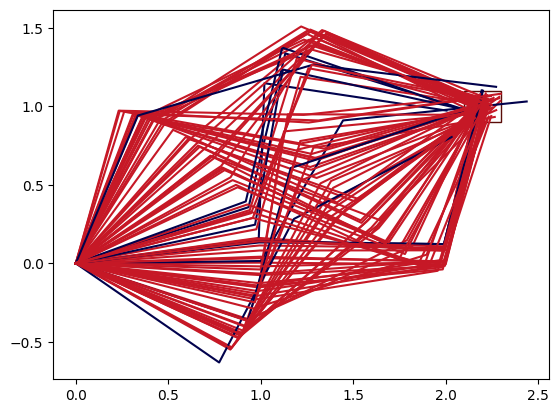

In [276]:
import matplotlib.patches as patches

n = 100
x_ = 2.2
y_ = 1.0
in_counter = 0
out_counter = 0
tol_area = 0.1
samples = th.tensor(np.random.normal([0, 0, 0], 1, size = (n, 3))).to(device)
y = [[x_, y_]] * n
y = th.tensor(y).to(device)
result = flow.backward(samples.float(), y.float())  

arm_pos = calc_arm_pos(result ).detach().numpy()
plt.figure()
arm_pos = calc_arm_pos(result).cpu().detach().numpy()

for i in range(len(arm_pos)):
    if (
        arm_pos[i, -1, 0] > x_ + tol_area
        or arm_pos[i, -1, 0] < x_ - tol_area
        or arm_pos[i, -1, 1] > y_ + tol_area
        or arm_pos[i, -1, 1] < y_ - tol_area
    ):
        out_counter += 1
        plt.plot(
            arm_pos[i, :, 0],
            arm_pos[i, :, 1],
            label="Original Data",
            c=col_blue,
            alpha=1,
        )
    else:
        in_counter += 1
        plt.plot(
            arm_pos[i, :, 0],
            arm_pos[i, :, 1],
            label="Original Data",
            c=col_red,
            alpha=1,
        )
rec = patches.Rectangle((x_ - tol_area, y_ - tol_area), 2*tol_area, 2*tol_area, linewidth=1, edgecolor=col_dark_red, facecolor='none')
plt.gca().add_patch(rec)

print(f"Percentage of points inside the area: {in_counter / n}")
print(f"Percentage of points outside the area: {out_counter / n}")

